In [3]:
import os
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import json
import logging
import nltk
import pickle as pkl
from sklearn.feature_extraction.text import CountVectorizer
from tokenizer import tokenizer
from gensim.corpora import Dictionary
from gensim.corpora.bleicorpus import BleiCorpus

In [4]:
# load args
with open("../args.json", "r") as f:
    args = json.load(f)

In [5]:
def cum_dist_plot(array, quantiles = [0.6, 0.8, 0.9, 0.95, 0.99], figsize=(16,9)):
    
    #cumulative distribution
    serie = pd.Series(array)
    serie_sorted = serie.sort_values(ascending=False)
    indexs = range(1, len(serie_sorted)+1)
    cum_dist = []

    cum = 0
    for value in serie_sorted:
        cum += value
        cum_dist.append(cum)

    cum_dist = pd.Series(cum_dist)
    #quantiles
    q_indexs = [] 
    q_cum = [] 

    labels = [f"q{int(100*q)}" for q in quantiles] 
    for q in quantiles:
        cut = cum_dist.max()*q
        slice = cum_dist[cum_dist<cut]
        i, value = slice.index[-1], slice.values[-1]
        q_indexs.append(i)
        q_cum.append(value)

    #plot cdf
    fig, ax = plt.subplots(figsize=figsize)        
    ax.plot(indexs, cum_dist)

    #plot quantiles
    ax.scatter(q_indexs, q_cum)
    for i, label in enumerate(labels):
        ax.annotate(label, (q_indexs[i], q_cum[i]))    
    print(q_indexs, q_cum)
    return ax

# 1. Loading Raw Data

In [6]:
# load documents
if args["target_data"]!="":
    # load data
    df = pd.read_csv(args["raw_data"], index_col = 'id_prose',
    usecols = ['id_prose', 'sin_fecha_siniestro', 'sin_relato'], sep=',')
    # change data type
    df['sin_fecha_siniestro'] = pd.to_datetime(df['sin_fecha_siniestro'])
    # sort by date
    df.sort_values('sin_fecha_siniestro', inplace=True)
    # select data between 2011-2016 and skip nulls
    df = df[(df['sin_fecha_siniestro']>=pd.Timestamp(2011,1,1)) 
        & (df['sin_fecha_siniestro']<pd.Timestamp(2017,1,1)) 
        & (df['sin_relato'].isnull()==False)]
    # export data
    path_to_export = args["raw_data"].split(".csv")[0]+".pkl"
    df.to_pickle(path_to_export) 
else:
    # load data
    df = pd.read_pickle(args["target_data"])

# load stopwords
if args["stopwords"]!="":
    with open(args["stopwords"], "r") as f:
        stopwords = [line.strip() for line in f]
else:
    stopwords = None

# load dicionary with homologations
if args["homol_dict"]!="":
    with open(args["homol_dict"], "r") as f:
        homol_dict = json.load(f)
else:
    homol_dict = None

# Data Analysis

In [7]:
vocabulary0 = set(word for doc in df["sin_relato"]for word in doc.split())
len(vocabulary0)

93203

### Text Processing

In [8]:
tf_vectorizer = CountVectorizer(analyzer='word', tokenizer=lambda text: tokenizer(text))
tf_vectorizer.fit(df["sin_relato"])
vocabulary = tf_vectorizer.get_feature_names()
frequency = tf_vectorizer.transform(df["sin_relato"]).toarray().sum(axis=0)

In [9]:
pd.Series(frequency).describe()

count    46708.000000
mean        41.689689
std        956.464381
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max      79877.000000
dtype: float64

In [10]:
qqs = [0.1, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.9, 0.95, 0.99]
pd.Series(frequency).quantile(qqs)

0.10      1.0
0.20      1.0
0.25      1.0
0.30      1.0
0.40      1.0
0.50      1.0
0.60      2.0
0.70      2.0
0.75      3.0
0.80      5.0
0.90     14.0
0.95     41.0
0.99    383.0
dtype: float64

[73, 429, 1512, 4199, 27234] [1167890, 1557740, 1752440, 1849871, 1927769]


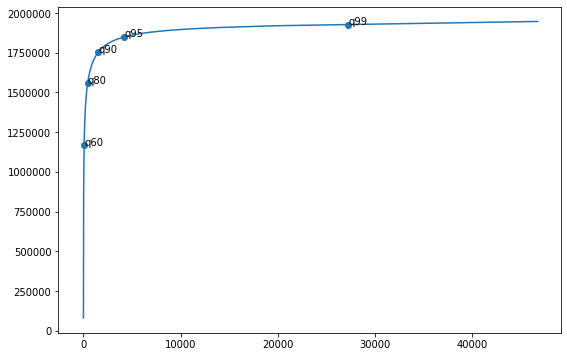

In [11]:
cum_dist_plot(frequency, quantiles = [0.6, 0.8, 0.9, 0.95, 0.99], figsize=(9,6))

El 50% de las palabras aparece una única vez y el 80% de las palabras tiene frecuencia menor o igual a 5. El 95% de la distribución acumulada puede explicarse con 4199 palabras de 46708 (9% aprox). Se concluye que la distribución de las palabras es sumamente pesada, por ende se debe recurrir a técnicas para que la cola sea menos pesada.

### Stopwords

Para extraer solo las palabras relevantes del corpus es necesario contar con una lista de palabras a remover debido a que aportan poca o nula información.

In [16]:
# initial list of stopwords from nltk
stopwords = nltk.corpus.stopwords.words("spanish")
len(stopwords)

313

In [13]:
# df_freq = pd.DataFrame({"word":vocabulary, "freq":frequency})
# df_freq.loc[:, "is_stop"] = df_freq.apply(lambda x: 1 if x["word"] in stopwords else 0, axis=1)
# len(df_freq[df_freq["is_stop"]==1])

202

In [2]:
#df_freq[df_freq["is_stop"]==0].sort_values("freq", ascending=False).iloc[110:130]

## lemmatization

# 2. Data Processing

In [ ]:
logger.info("***Data Processing***")

def split_docs(df, slice_type):
    """
    Input
        df: pandas.DataFrame, corpus dataframe.
        slice_type: str, type of temporal division of the corpus ('year', 'quarter' or 'month').
    Output
        df_slices: pandas.DataFrame, dataframe with slice assignment for each pair of (year, month).
    """
    df_slices = df[["year", "month"]].drop_duplicates()
    df_slices.reset_index(inplace=True, drop=True)
    df_slices["slice"] = 0
    N = len(df_slices)
    if slice_type == "year":
        steps = 12
        M = int(N/steps)
        slices = range(1, M+1)
    elif slice_type == "quarter":
        steps = 3
        M = int(N/steps)
        slices = range(1, M+1)
    else:
        # slice_type == "month"
        steps = 1
        slices = range(1, N+1)

    for slice in slices:
        df_slices.loc[steps*(slice-1):steps*slice, "slice"] = slice

    return df_slices

# group corpus into slices
df.loc[:, "year"] = df.apply(lambda x: x["sin_fecha_siniestro"].year, axis=1)
df.loc[:, "month"] = df.apply(lambda x: x["sin_fecha_siniestro"].month, axis=1)
df.loc[:, "slice"] = 0
df_slices = split_docs(df, args["slice_type"])
slices = df_slices["slice"].unique()

for row in df_slices.values: 
    year, month, slice = row[0], row[1], row[2]
    df.loc[(df["year"]==year) & (df["month"]==month), "slice"] = slice

# make folder to export results
path_to_save = f'{args["corpus"]}{args["slice_type"]}/'
if os.path.exists(path_to_save):
    # remove pre executions
    shutil.rmtree(path_to_save)
os.makedirs(path_to_save)

for slice in slices:
    logger.info(f"***Slices Completed:{slice-1}/{slices[-1]}***")
    
    docs = df[df["slice"] == slice]["sin_relato"]
    logger.info(f"Corpus size: {len(docs)}")

    logger.info("Extracting Vocabulary")

    tokenizer_args = {"stopwords": stopwords, "homol_dict": homol_dict, 
                      "stemming": args["stemming"], "lemmatization": args["lemmatization"]}
    tf_vectorizer = CountVectorizer(analyzer='word', tokenizer=lambda text: tokenizer(text, **tokenizer_args))
    tf_vectorizer.fit(docs)
    vocabulary = tf_vectorizer.get_feature_names()
    frequency = tf_vectorizer.transform(docs).toarray().sum(axis=0)
    word_freq = {'vocabulary':pd.Series(vocabulary), 'frequency': pd.Series(frequency)}
    df_word_freq = pd.DataFrame(word_freq)

    logger.info(f"Vocabulary size: {len(vocabulary)}")

    # remove words with less frequency and with little chars
    vocabulary = df_word_freq[(df_word_freq['frequency']>=2) & (df_word_freq['vocabulary'].str.len()>3)]['vocabulary'].to_list()
    logger.info(f"Vocabulary size after elimination: {len(vocabulary)}")

    logger.info("Getting corpus in Blei’s LDA-C format")

    # tokenized corpus using vocabulary
    tokenizer_args = {"stopwords": stopwords, "homol_dict": homol_dict, "vocabulary": vocabulary, 
                      "lemmatization": args["lemmatization"], "stemming": args["stemming"]}
    corpus = [tokenizer(doc, **tokenizer_args) for doc in docs]
    # remove empty documents
    corpus = [doc for doc in corpus if len(doc)>0]

    logger.info(f"Corpus size after elimination of empty docs: {len(corpus)}")

    # map each word to an id {id->word}
    dictionary = Dictionary(corpus)
    # a document is a list of tuples, each tuples has two element, the first is the id of the word and the second is its frequency
    corpus = [dictionary.doc2bow(text) for text in corpus]

    logger.info("Saving Corpus")
    # save dictionary and corpus 
    zeros = "0"*(len(str(slices[-1]))-len(str(slice)))
    slice_string = f"{zeros}{slice}"
    dictionary.save(f"{path_to_save}dictionary_{slice_string}.dict")
    BleiCorpus.serialize(f"{path_to_save}corpus_{slice_string}.mm", corpus)

logger.info("***Data Processing Completed***")

# 3. Innovation rate

How much change the vocabulary between adjacent epoch

In [7]:
# load dictionaries
path_corpus = f'{args["corpus"]}{args["slice_type"]}'
dict_files = sorted([file for file in os.listdir(path_corpus) if ".dict" in file])
dictionaries = {}
slices = range(1, len(dict_files)+1)
for slice in slices:
    path_dict = f'{path_corpus}/{dict_files[slice-1]}'
    token2id = Dictionary.load(path_dict).token2id
    dictionaries[slice] = token2id

In [25]:
innovation_data = []
for slice in slices[:-1]:
    vocabulary1 = set(dictionaries[slice].keys())
    vocabulary2= set(dictionaries[slice+1].keys())
    
    old_vocabulary = len(vocabulary1)
    new_vocabulary = len(vocabulary2)
    
    old_words = round(100*len(vocabulary1-vocabulary2)/old_vocabulary, 2)
    new_words = round(100*len(vocabulary2-vocabulary1)/old_vocabulary, 2)
    vocabulary_change = {"slice":slice+1, "old_vocabulary": old_vocabulary, "new_vocabulary": new_vocabulary, 
     "%old_words": old_words, "%new_words":new_words}
    innovation_data.append(vocabulary_change)


In [26]:
innovation_rate = pd.DataFrame(innovation_data)
innovation_rate

,slice,old_vocabulary,new_vocabulary,%old_words,%new_words
0,2,1314,1418,28.23,36.15
1,3,1418,1497,28.84,34.41
2,4,1497,1551,30.33,33.93
3,5,1551,1457,33.72,27.66
4,6,1457,1507,30.95,34.39
5,7,1507,1514,31.52,31.98
6,8,1514,1498,32.43,31.37
7,9,1498,1496,32.71,32.58
8,10,1496,1722,27.87,42.98
9,11,1722,1573,36.53,27.87


In [27]:
innovation_rate.describe()

,slice,old_vocabulary,new_vocabulary,%old_words,%new_words
count,23.00000,23.000000,23.000000,23.000000,23.000000
mean,13.00000,1657.304348,1684.347826,30.841739,32.664783
std,6.78233,176.896332,169.413858,2.170793,3.492412
min,2.00000,1314.000000,1418.000000,27.540000,25.650000
25%,7.50000,1502.500000,1510.500000,29.420000,30.990000
50%,13.00000,1686.000000,1722.000000,30.330000,32.580000
75%,18.50000,1797.000000,1816.500000,32.300000,34.400000
max,24.00000,1926.000000,1936.000000,36.530000,42.980000


```python
# Extraer stopwords contextuales: palabras muy frecuentes que aportan poca información
stopwords_filter = ['veh', 'vh', 'culo', 'aut', 'camion', 'camión','rob', 'denun', 'dej', 
                    'daño', 'dano', 'daos', 'perc' ,'sinies' ,'llev' ,'volver' ,'sali' ,
                    'hrs' ,'dedu' ,'hecho' , 'habia', 'busc' ,'regre' ,'aseg' ,
                    'frent' ,'comuna' ,'direcc' ,'aprox' ,'circun' ,'lleg' , 'afuera' ,
                    'hora' ,'indica' ,'ubica' ,'minut' ,'conta', 'presen', 'senal', 
                    'señal', 'web', 'descrip', 'carabi', 'fech', 'avis', 'docu', 'ppu',
                    'dya', 'mario', 'medina', 'alcoholemiano'
                   ]
#ppu:patente, web: página web para denunciar

not_stopwords = set(['autopista', 'autopistas', 'autoservicio', 'automático', 'algarrobo', 'petrobras'])
contextual_stopwords = contextual_stopwords-not_stopwords
contextual_stopwords = contextual_stopwords.union(set(['via', 'vía', 'uf', 'numero', 'número']))
```

# To Do

Ver como capturar patrón horario, usando intervalos horarios a partir de números o palabras:
- tiempo = [ 'am', 'mañana', 'manana', 'pm', 'noche', 'madrugada', 'anoche']

Crear diccionario de homologaciones. Ejemplo:
- estacionar, bajar
- arma_fuego: [pistola, arma de fuego, ..]
- sujetos, tipos, individiuos, persona, tipo, personas bajar

Trabajar en la generación de frases, ejemplo:
- cajero_automático = [cajero automático]
- estacion_central = ['estación central', 'estacion central']
- estacion_de_servicio = ['estación de servicio', 'estacion de servicio', 'autoservicio', 'estacion de autoservicio ']
- estacion_del_metro = ['estación del metro']

Consideraciones
- Correción ortográfica: embeddings (60 ms) y permutaciones (230 ms).
- Lematización: spacy (5 ms), CREA (137 ns), se cae con faltas ortográficas
- Palabras cortadas: realizar búsqueda exhaustiva de carácteres que cortan palabras.